In [12]:
import os
import time
import torch

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from sparsecoding.preprocess import patch_images, preprocess_images
from sparsecoding import inference

from sparsecoding import models
from sparsecoding.visualization import plot_dictionary

### Define constants and load data

In [2]:
img_dir = os.path.join(os.environ['DATA_PATH'], 'IMAGES.mat')
images = loadmat(img_dir)['IMAGES']
images = torch.tensor(images)
print(images.shape)

torch.Size([512, 512, 10])


In [3]:
n_images = images.shape[-1]
n_divisions = 32

image_data, n_images, n_divisions, patch_size_x, patch_size_y = patch_images(images, n_divisions=n_divisions)
data = preprocess_images(image_data, patch_size_x, patch_size_y)

n_samples, n_features = data.shape

### Visualize patches

<IPython.core.display.Javascript object>


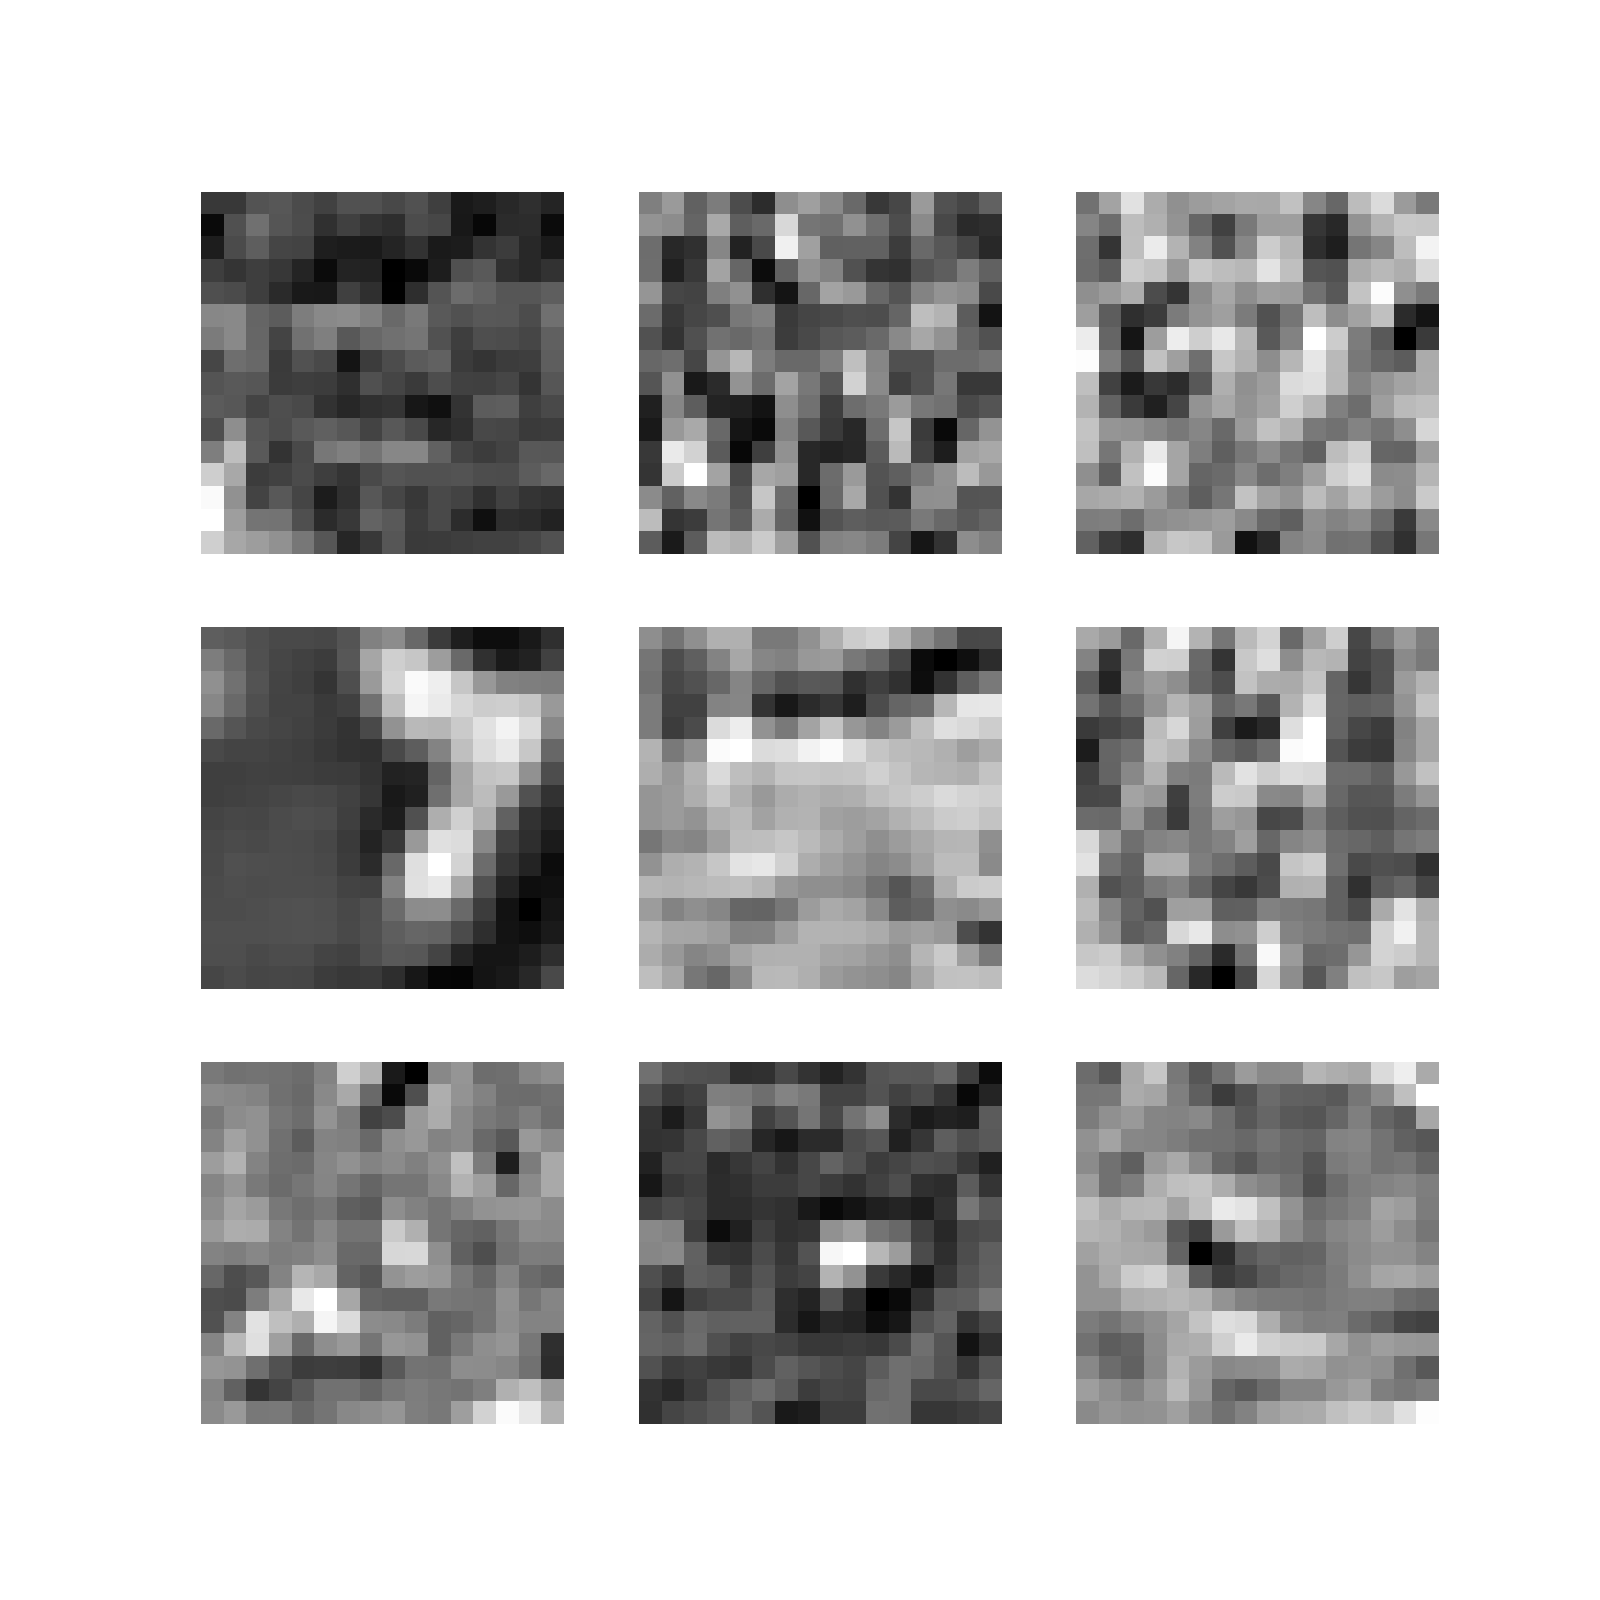

In [4]:
%matplotlib notebook

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size_x,patch_size_y]), cmap="gray")
plt.show()

### Sparse Coding

In [5]:
# define random dictionary
n_basis = 100
n_features = patch_size_x**2
dictionary = 2*torch.rand([n_features,n_basis]) - 1

# verify LCA method 
lca = inference.LCA(coeff_lr=1e-3,threshold=0.1,n_iter=300)
A = lca.infer(data[:,:],dictionary)

<IPython.core.display.Javascript object>


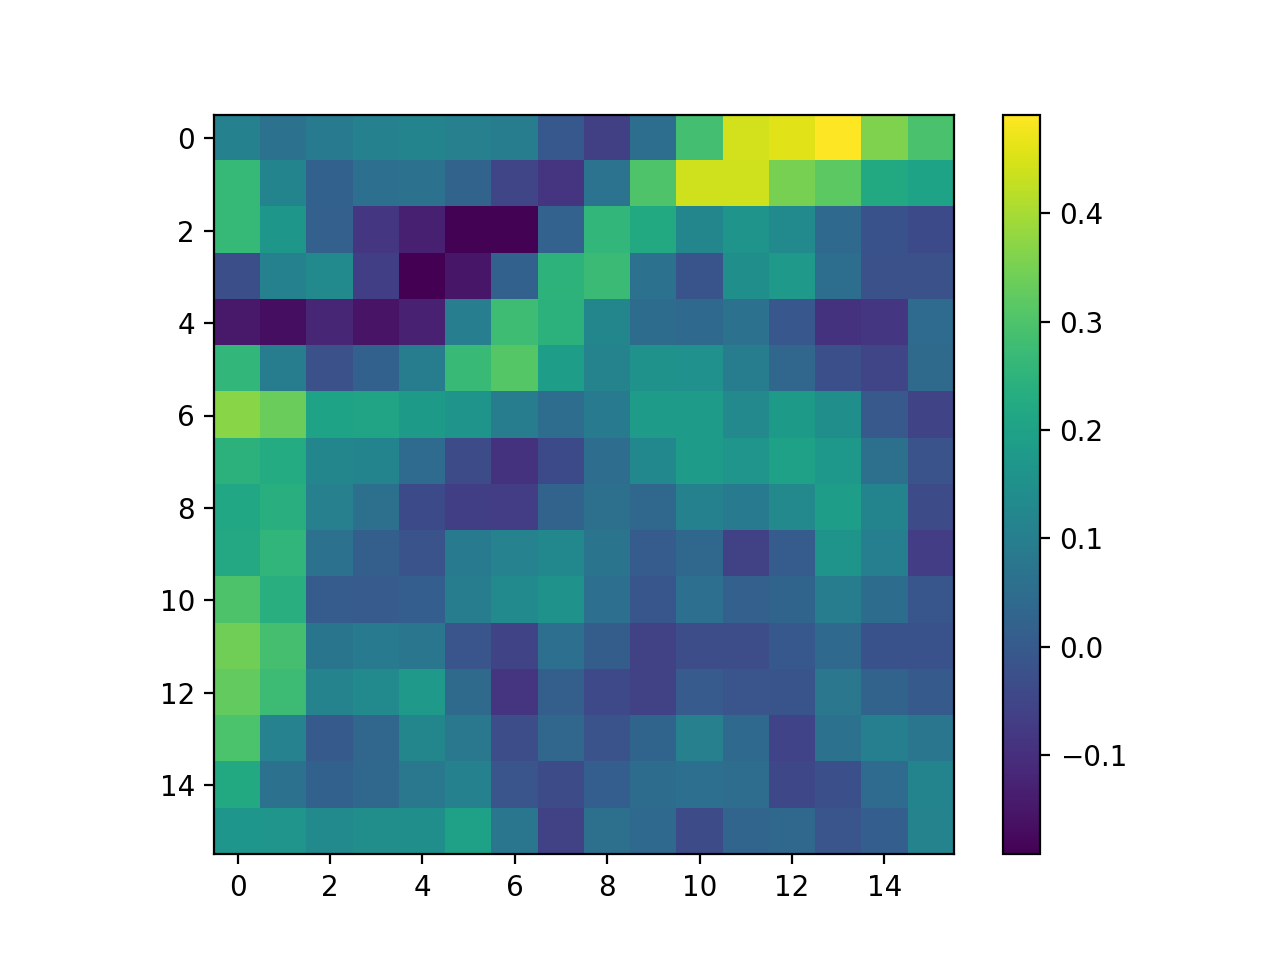

In [6]:
fig,ax = plt.subplots()
hax = ax.imshow(data[0,:].detach().reshape(patch_size_x,patch_size_x))
plt.colorbar(hax)

<IPython.core.display.Javascript object>


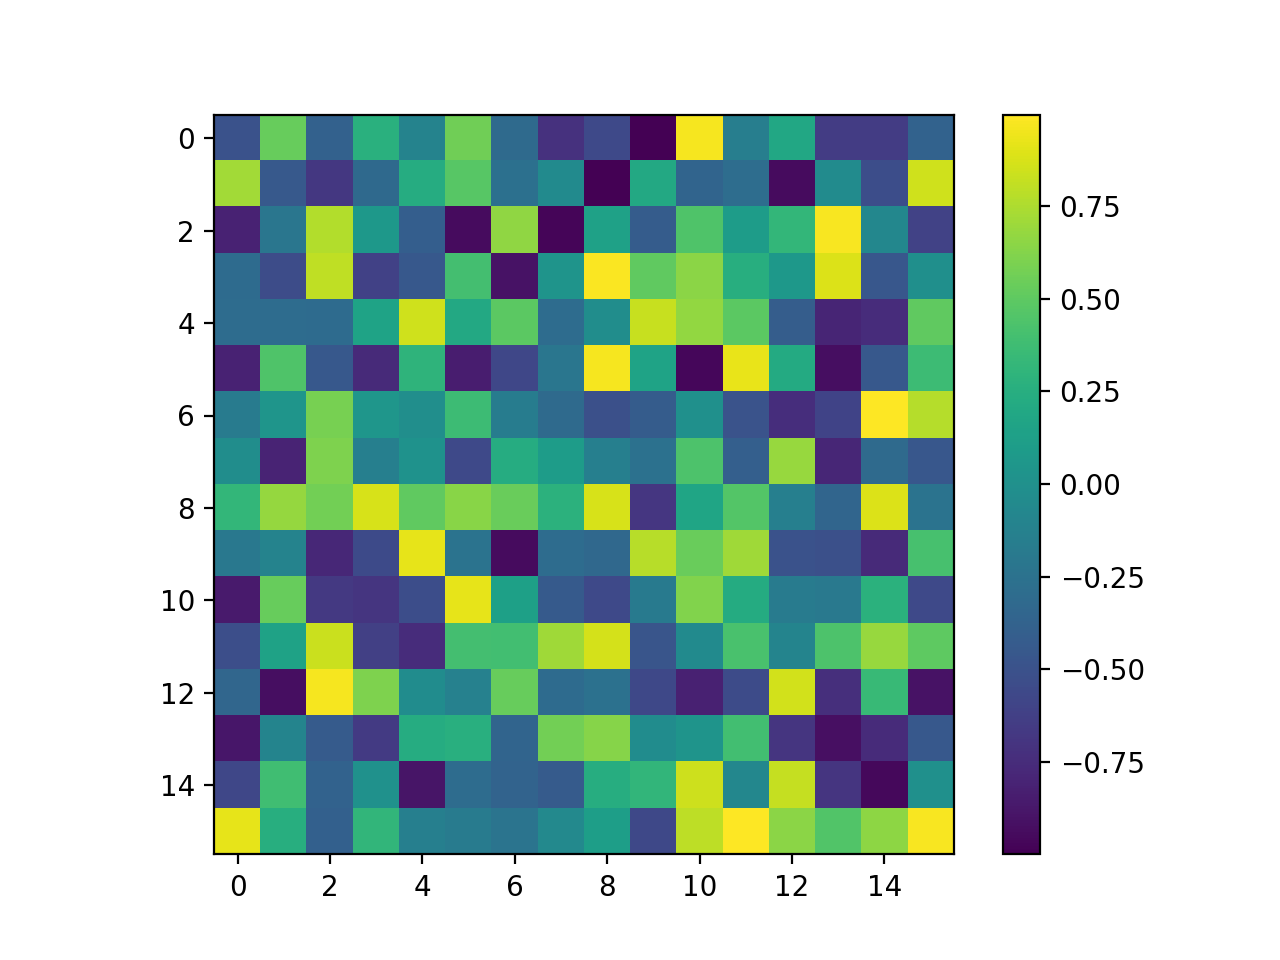

In [7]:
fig,ax = plt.subplots()
hax = ax.imshow(dictionary[:,0].detach().reshape(patch_size_x,patch_size_x))
plt.colorbar(hax)

<IPython.core.display.Javascript object>


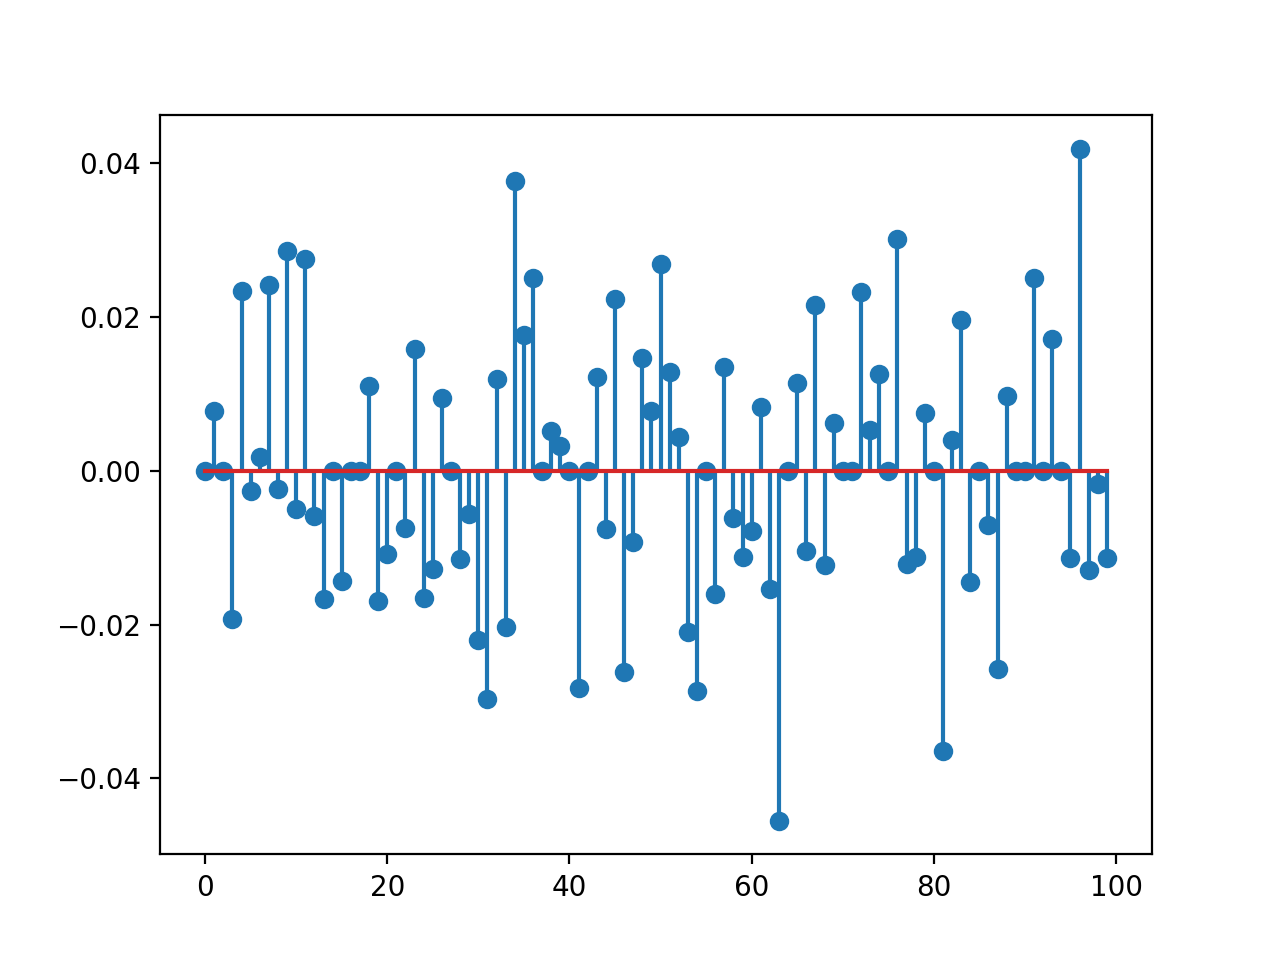

<StemContainer object of 3 artists>

In [8]:
fig,ax = plt.subplots()
ax.stem(A[2,:].reshape(-1))

In [9]:
### DEFINE MODEL
sc = models.SparseCoding(inference_method=lca.infer,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

<IPython.core.display.Javascript object>


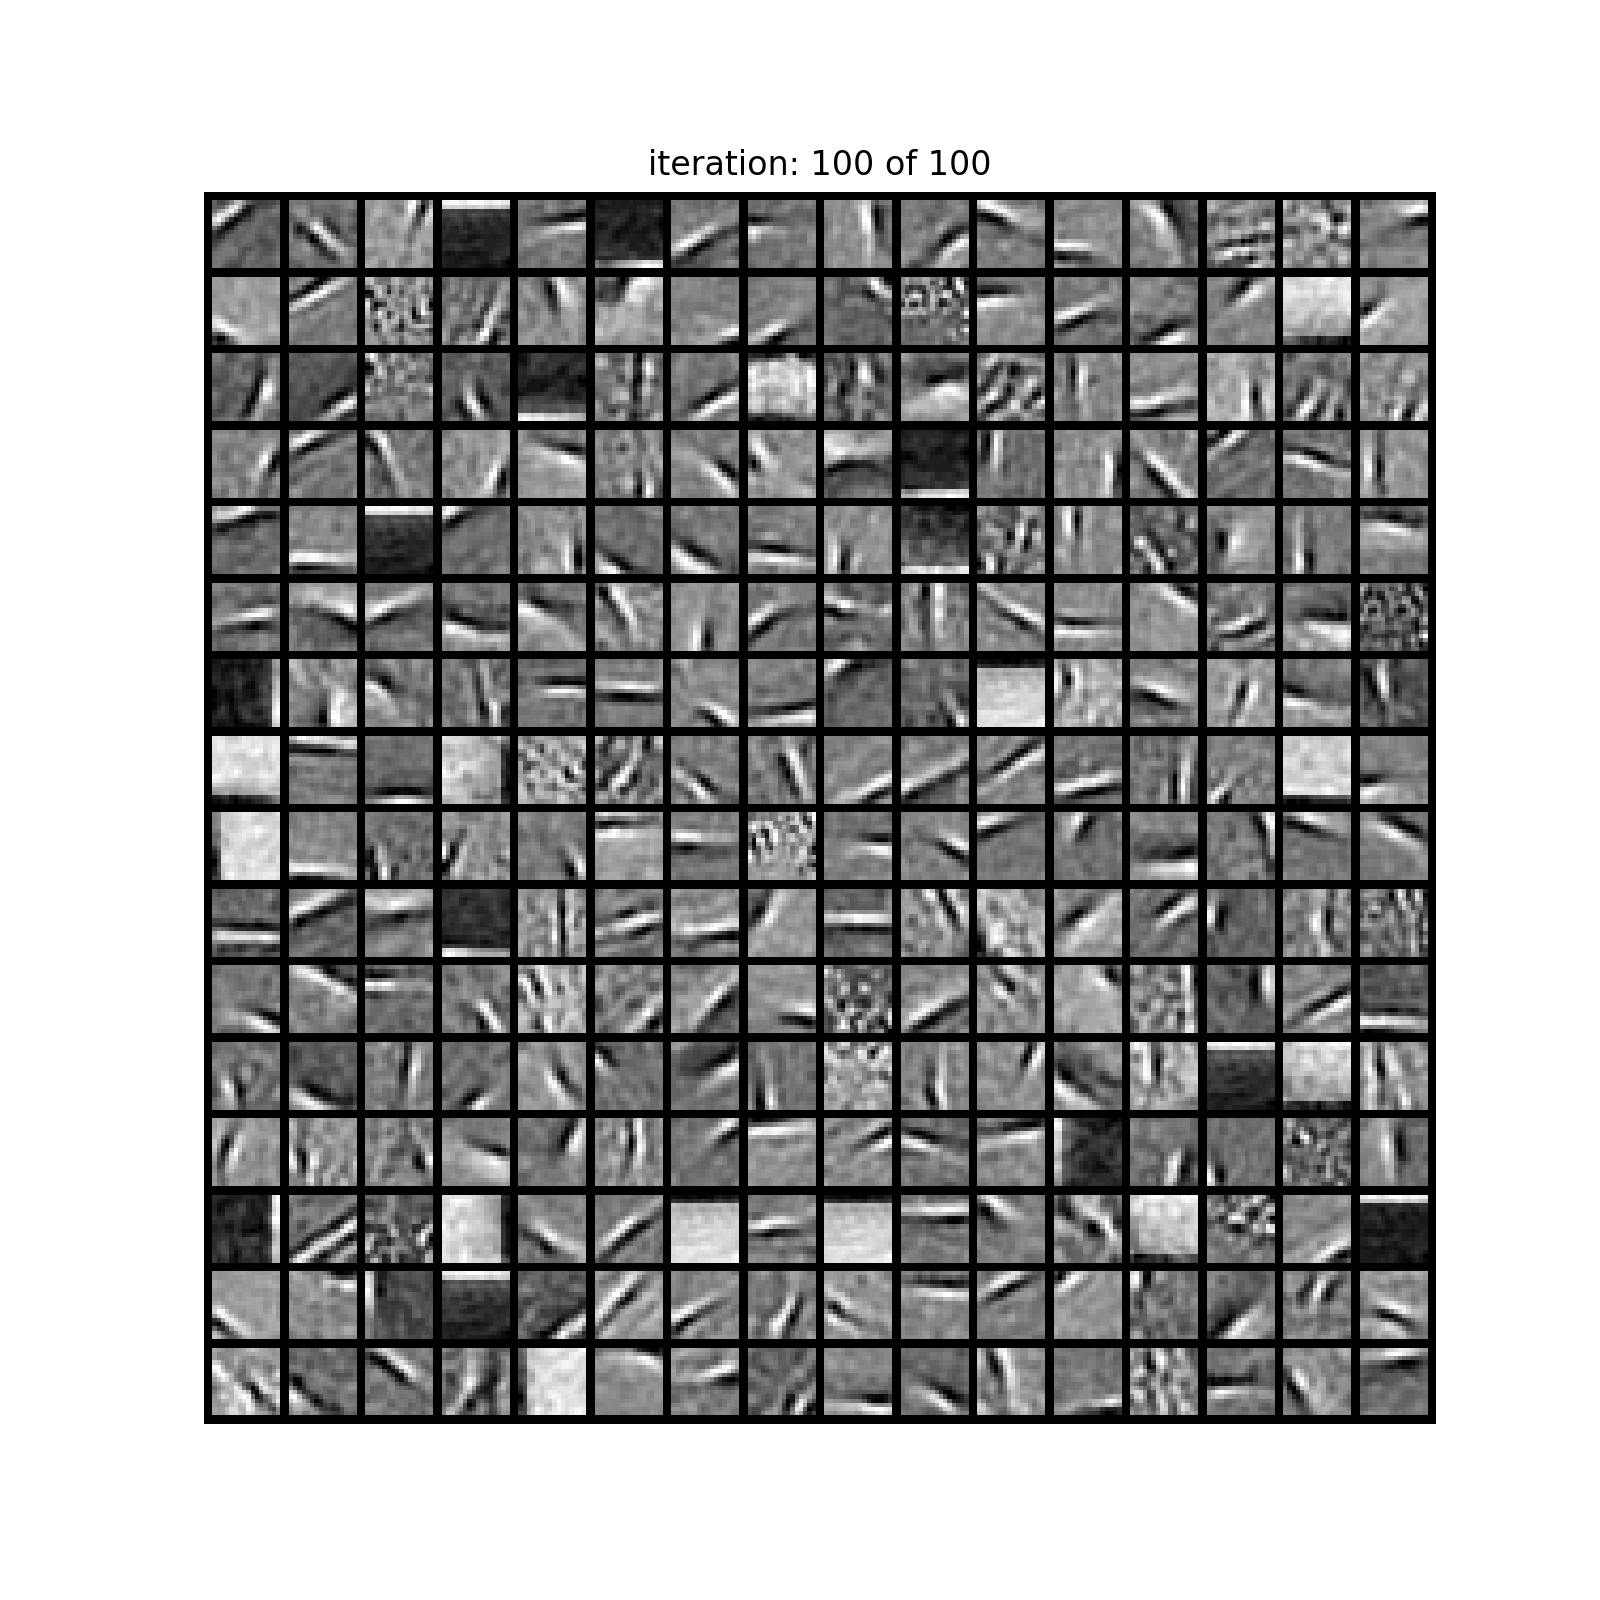

In [10]:
### LEARN DICTIONARY
%matplotlib notebook

n_epoch = 100
montage_update_rate = 10

# plot variables
nrow = 16
fig,ax = plot_dictionary(sc.dictionary,nrow=nrow)

energies = np.asarray([])

for i in range(n_epoch//montage_update_rate):
    # learn dictionary
    energy = sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)
    energies = np.concatenate([energies,energy])
    # update montage
    fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(i*montage_update_rate,n_epoch),nrow=nrow)

fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(n_epoch,n_epoch),nrow=nrow)

<IPython.core.display.Javascript object>


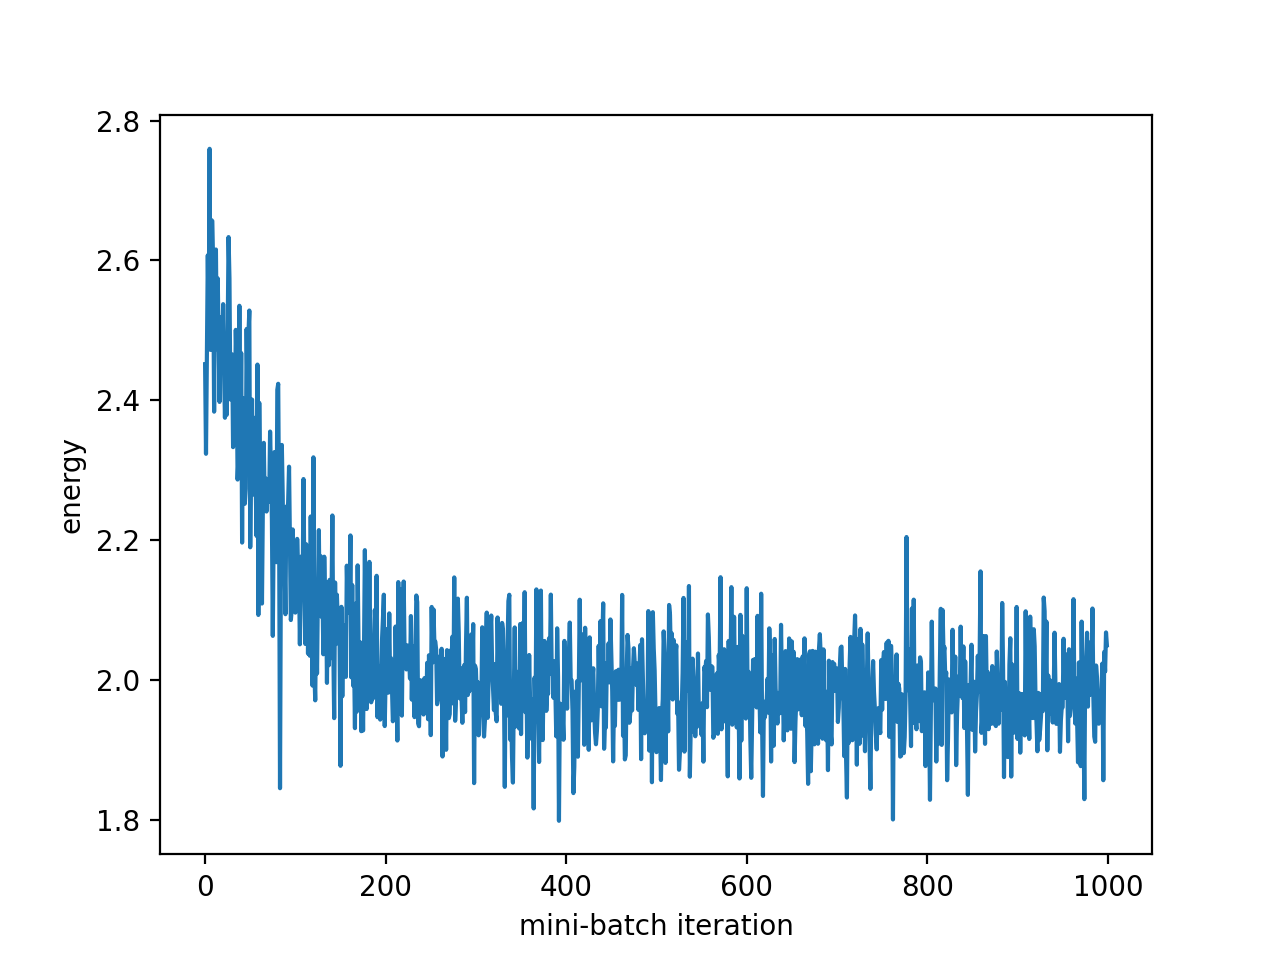

Text(0, 0.5, 'energy')

In [11]:
fig,ax = plt.subplots()
ax.plot(energies)
ax.set_xlabel('mini-batch iteration')
ax.set_ylabel('energy')